**Projet personnel de reconnaissance d'émotions sur des visages**

In [2]:
exec(open("import_lib.py").read())

In [3]:
data_dir_train = "./archive/train/"
data_dir_test = "./archive/test/"
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [4]:
nbr_emotion = {}
nbr_emotion_perc = {}
for emotion in emotions:
    nbr_emotion[emotion] = len(os.listdir(f"{data_dir_train}{emotion}"))
    nbr_emotion_perc[emotion] = len(os.listdir(f"{data_dir_train}{emotion}"))/28709
display(nbr_emotion)

{'angry': 3995,
 'disgust': 436,
 'fear': 4097,
 'happy': 7215,
 'neutral': 4965,
 'sad': 4830,
 'surprise': 3171}

In [5]:
nbr_emotion = {}
nbr_emotion_perc = {}
for emotion in emotions:
    nbr_emotion[emotion] = len(os.listdir(f"{data_dir_test}{emotion}"))
    nbr_emotion_perc[emotion] = len(os.listdir(f"{data_dir_test}{emotion}"))/28709
display(nbr_emotion)

{'angry': 958,
 'disgust': 111,
 'fear': 1024,
 'happy': 1774,
 'neutral': 1233,
 'sad': 1247,
 'surprise': 831}

In [6]:
labels_test = np.zeros(7178, dtype=int)
labels_test[958:958+111] = 1
labels_test[958+111:958+111+1024] = 2
labels_test[958+111+1024:958+111+1024+1774] = 3
labels_test[958+111+1024+1774:958+111+1024+1774+1233] = 4
labels_test[958+111+1024+1774+1233:958+111+1024+1774+1233+1247] = 5
labels_test[958+111+1024+1774+1233+1247:958+111+1024+1774+1233+1247+831] = 6
labels_test

array([0, 0, 0, ..., 6, 6, 6])

In [7]:
labels_train = np.zeros(28709, dtype=int)
labels_train[3995:3995+436] = 1
labels_train[3995+436:3995+436+4097] = 2
labels_train[3995+436+4097:3995+436+4097+7215] = 3
labels_train[3995+436+4097+7215:3995+436+4097+7215+4965] = 4
labels_train[3995+436+4097+7215+4965:3995+436+4097+7215+4965+4830] = 5
labels_train[3995+436+4097+7215+4965+4830:3995+436+4097+7215+4965+4830+3171] = 6
labels_train

array([0, 0, 0, ..., 6, 6, 6])

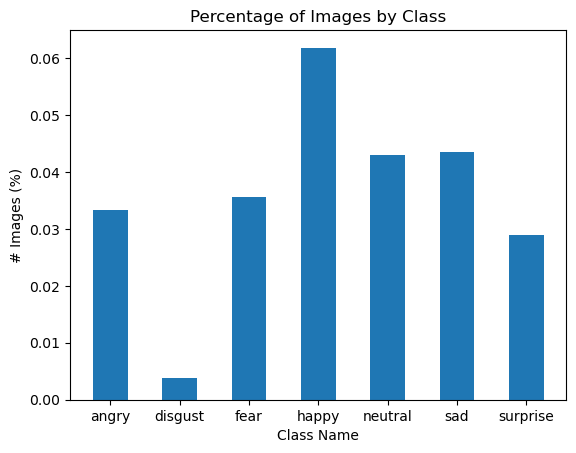

In [9]:
plt.bar(nbr_emotion_perc.keys(), nbr_emotion_perc.values(), width = .5);plt.title("Percentage of Images by Class");plt.xlabel('Class Name');plt.ylabel('# Images (%)')
plt.show()

In [123]:
data_h_app=[]
data_w_app = []
for i in glob.glob(f"{data_dir_train}**/*.jpg", recursive=True):
    img = Image.open(i)
    h = np.array(img).shape[0]
    w = np.array(img).shape[1]
    data_h_app.append(h)
    data_w_app.append(w)
data_h_app_df = pd.DataFrame(data_h_app)
data_h_app_df.rename(columns={0:"height"}, inplace=True)
data_w_app_df = pd.DataFrame(data_w_app)
data_w_app_df.rename(columns={0:"width"}, inplace=True)
data_h_w=pd.concat([data_h_app_df,data_w_app_df], axis=1)


In [126]:
data_w_app_df.rename(columns={0:"width"}, inplace=True)
data_h_w=pd.concat([data_h_app_df,data_w_app_df], axis=1)
data_h_w

,height,width
0,48,48
1,48,48
2,48,48
3,48,48
4,48,48
...,...,...
28704,48,48
28705,48,48
28706,48,48
28707,48,48


Text(0.5, 1.0, 'Size of every image')

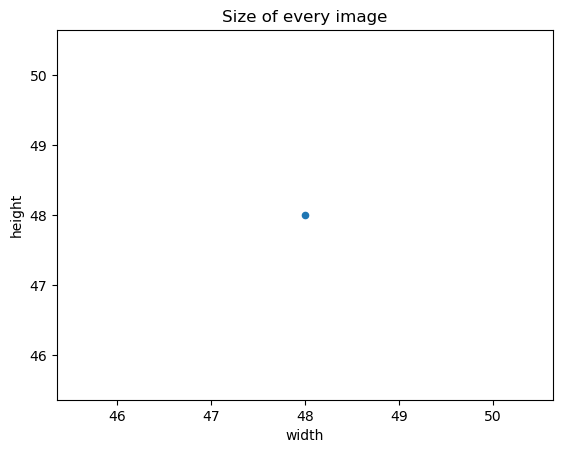

In [131]:
sizes = data_h_w.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.plot.scatter(x='width', y='height')
plt.title("Size of every image")

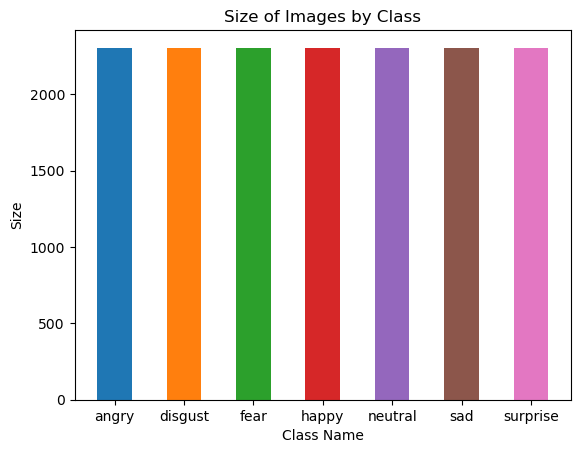

In [26]:
for emotion in emotions:
    # Set image path
    for i in glob.glob(f"{data_dir_test}**/*.jpg", recursive=True):
        data_unflatten = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    plt.bar(emotion, data_unflatten.size, width = .5);plt.title("Size of Images by Class");plt.xlabel('Class Name');plt.ylabel('Size')


In [10]:
pca = PCA().fit(df_tot_train)
X_pca = pca.transform(df_tot_train)

NameError: name 'df_tot_train' is not defined

(0.0, 2305.0)

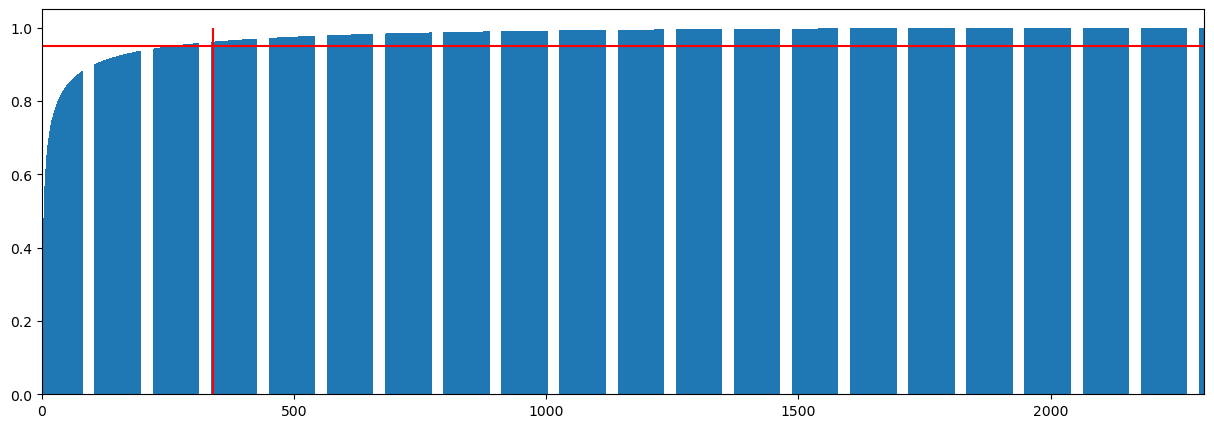

In [28]:
CVar = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(15,5))
plt.bar(np.arange(1, 1+ X_pca.shape[1]),CVar)
plt.hlines(0.95, 0, 1+ X_pca.shape[1], color='red')
plt.vlines(340, 0, 1,color = 'red')
plt.xlim(0,1+ X_pca.shape[1])

In [29]:
pca = PCA(n_components=340).fit(df_tot_train)
components = pca.transform(df_tot_train)
projected = pca.inverse_transform(components)
dataframe_proj = pd.DataFrame(projected)


In [ ]:

plt.figure(figsize=(15,21))
plt.suptitle('PCA components')
plt.subplot(3,1,1)
sns.barplot(data=components, x= 'index', y='pc_0')
plt.xticks(rotation = 90)

plt.subplot(3,1,2)
sns.barplot(data=components, x= 'index', y='pc_1')
plt.xticks(rotation = 90)

plt.subplot(3,1,3)
sns.barplot(data=components, x= 'index', y='pc_2')
plt.xticks(rotation = 90)



plt.tight_layout()

plt.show()


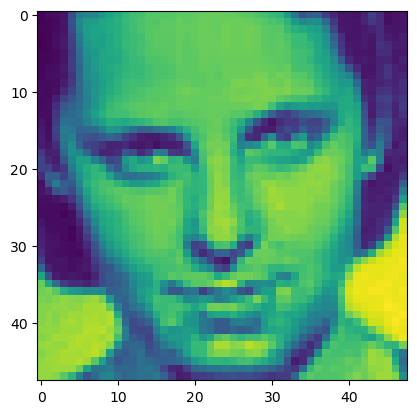

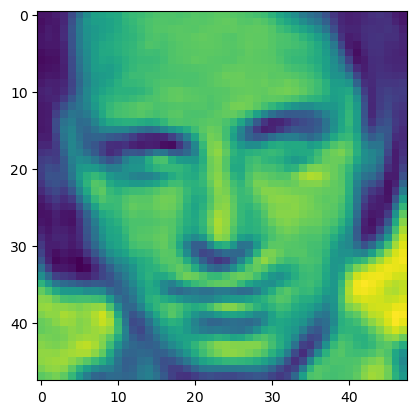

In [48]:
series_obj = df_tot_train.iloc[20000]
series_obj1 = dataframe_proj.iloc[20000]
arr = series_obj.values
arr1 = series_obj1.values
reshaped_arr = arr.reshape((48, 48))
reshaped_arr1 = arr1.reshape((48, 48))
plt.figure()
plt.imshow(reshaped_arr)
plt.figure()
plt.imshow(reshaped_arr1)
plt.show()

**Exemple de boucle d'itération à tavers les différents dossiers**

In [7]:
for emotion in emotions:
    # Set image path
    file_path_type = [f"{data_dir_train}{emotion}/*.jpg"]
    display(file_path_type)


['./archive/train/angry/*.jpg']

['./archive/train/disgust/*.jpg']

['./archive/train/fear/*.jpg']

['./archive/train/happy/*.jpg']

['./archive/train/neutral/*.jpg']

['./archive/train/sad/*.jpg']

['./archive/train/surprise/*.jpg']

**Création dataframe global train et test**

In [ ]:
# data_train = []

# for i in glob.glob(f"{data_dir_train}**/*.jpg", recursive=True):
#     data_unflatten = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
#     data_flatten = data_unflatten.flatten()
#     data_train.append(data_flatten)
# df_train=pd.DataFrame(data_train)

# data_test = []

# for i in glob.glob(f"{data_dir_test}**/*.jpg", recursive=True):
#     data_unflatten = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
#     data_flatten = data_unflatten.flatten()
#     data_test.append(data_flatten)
# df_tot_test=pd.DataFrame(data_test)

**Sauvegarde et chargement du dataframe global  train et test**

In [ ]:
# df_tot_train = df_train.copy()
# df_tot_train.to_csv("C:/Users/admindc/Documents/Projet_final/df_tot_train.csv", compression="zip")
# df_tot_test = df_tot_test.copy()
# df_tot_test.to_csv("C:/Users/admindc/Documents/Projet_final/df_tot_test.csv", compression="zip")

In [11]:
df_tot_train_load = pd.read_csv("C:/Users/admindc/Documents/Projet_final/df_tot_train.csv",compression="zip")
df_tot_train = df_tot_train_load.drop(['Unnamed: 0'], axis=1)
df_tot_test_load = pd.read_csv("C:/Users/admindc/Documents/Projet_final/df_tot_test.csv",compression="zip")
df_tot_test = df_tot_test_load.drop(['Unnamed: 0'], axis=1)

**Définir les catégories et afficher une image aléatoire de chacunes**

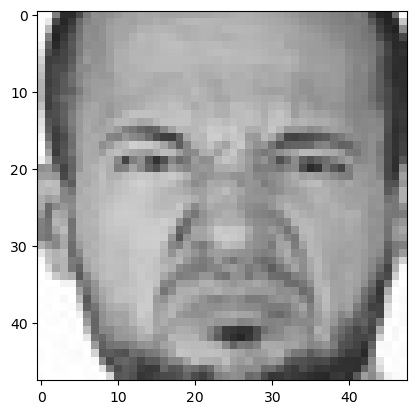

In [26]:
plt.imshow(inputImage)

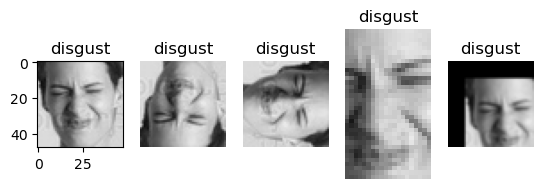

In [29]:
file_path_type = [f"{data_dir_train}disgust/*.jpg"] # Exemple : file_path_type = "./archive/train/angry/Training_3908.jpg"
images = glob.glob(random.choice(file_path_type))
random_image = random.choice(images)

# Read input image:
inputImage = cv2.imread(random_image)
grayscaleImage = inputImage.copy()
img_flip = cv2.flip(grayscaleImage,0)
img_rot = cv2.rotate(grayscaleImage, cv2.ROTATE_90_CLOCKWISE)
img_crop = grayscaleImage[5:40, 15:35]
T = np.float32([[1, 0, 48/5], [0, 1, 48/5]])
img_translation = cv2.warpAffine(grayscaleImage, T, (48, 48))
plt.figure()
plt.subplot(151)
plt.imshow(grayscaleImage)
plt.title(emotions[1])
plt.subplot(152)
plt.imshow(img_flip)
plt.axis("off")
plt.title(emotions[1])
plt.subplot(153)
plt.imshow(img_rot)
plt.axis("off")
plt.title(emotions[1])
plt.subplot(154)
plt.imshow(img_crop)
plt.axis("off")
plt.title(emotions[1])
plt.subplot(155)
plt.imshow(img_translation)
plt.axis("off")
plt.title(emotions[1])
plt.show()

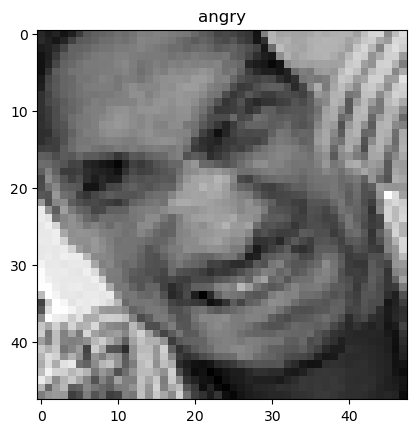

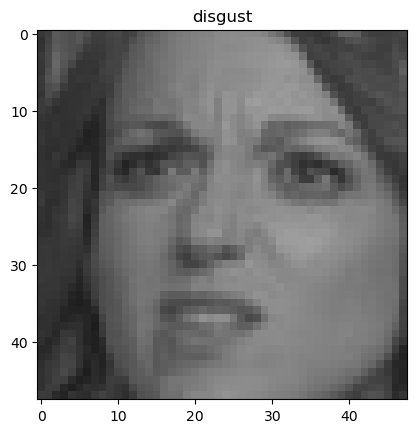

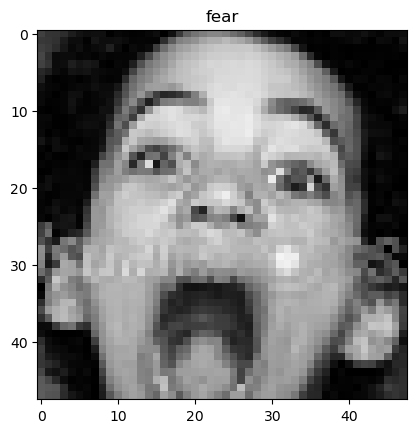

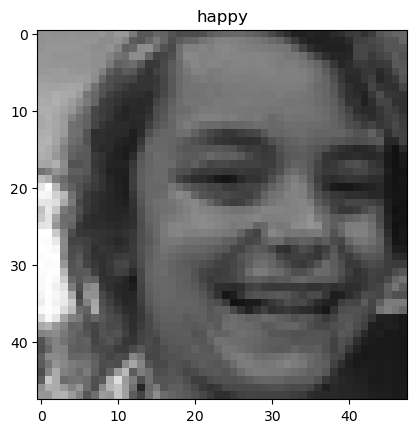

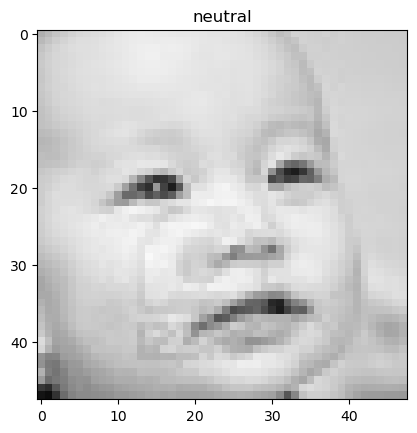

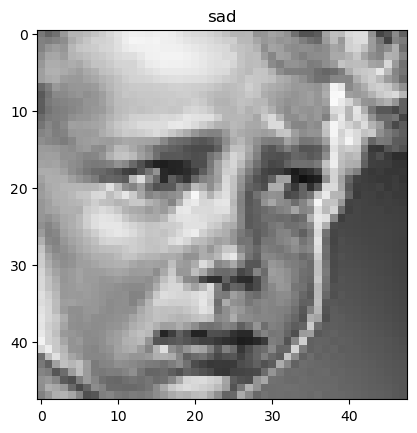

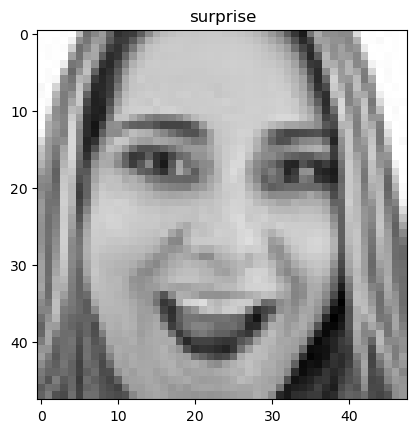

In [14]:
for emotion in emotions:
    # Set image path
    file_path_type = [f"{data_dir_train}{emotion}/*.jpg"] # Exemple : file_path_type = "./archive/train/angry/Training_3908.jpg"
    images = glob.glob(random.choice(file_path_type))
    random_image = random.choice(images)
    
    # Read input image:
    inputImage = cv2.imread(random_image)
    grayscaleImage = inputImage.copy()

    # Convert BGR to grayscale:
    # grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    plt.figure()
    plt.title(emotion)
    plt.imshow(grayscaleImage)

**Automatisation de la création d'un dictionnaire de dataframes pour chaque émotions**

In [10]:
# d = {}
# for i in emotions:
#     data = []
#     for j in glob.glob(f"{data_dir_train}{i}/*.jpg", recursive=True):
#         data_unflatten = cv2.imread(j, cv2.IMREAD_GRAYSCALE)
#         data_flatten = data_unflatten.flatten()
#         data.append(data_flatten)
#     d["df_" + i] = pd.DataFrame(data)



**Sauvegarde du dictionnaire de dataframes pour chaque émotions**

In [11]:
# with open('dictionaire_df.pickle', 'wb') as handle:
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Sauvegarde de chaque dataframe de chaque émotions**

In [12]:
# for i in emotions:
#     d["df_" + i].to_csv(f"C:/Users/admindc/Documents/Projet_final/{'df_' + i}.csv", compression="zip")

**Chargement du dictionnaire de dataframes pour chaque émotions**

In [12]:
with open('dictionaire_df.pickle', 'rb') as handle:
    d = pickle.load(handle)

**Affichage des photos moyennes de chaque émotions**

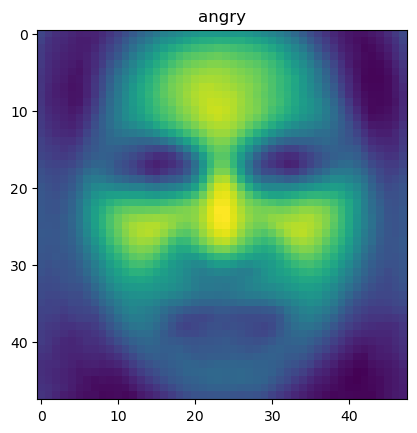

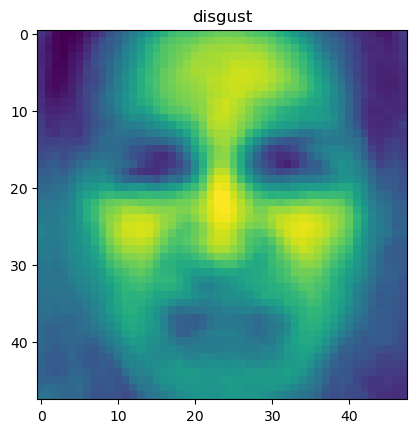

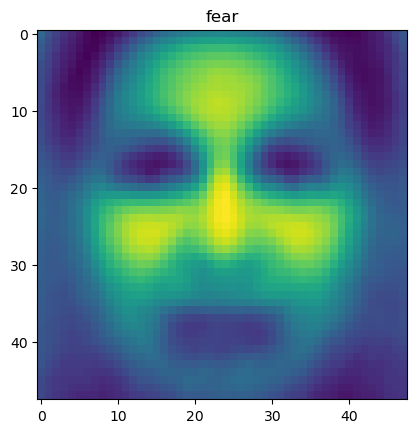

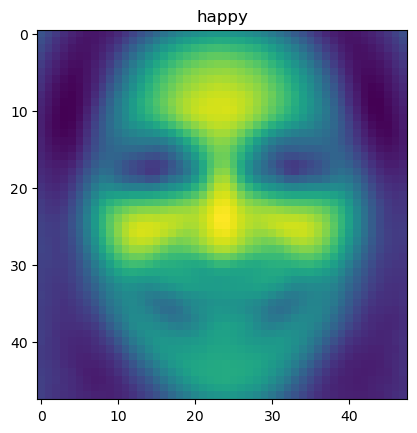

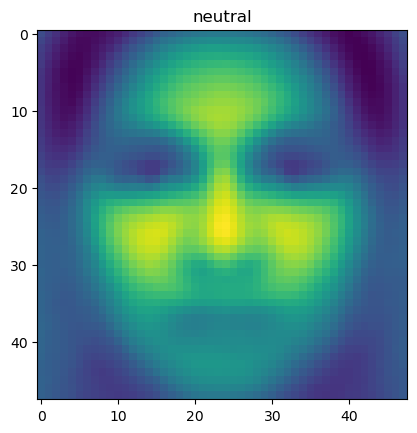

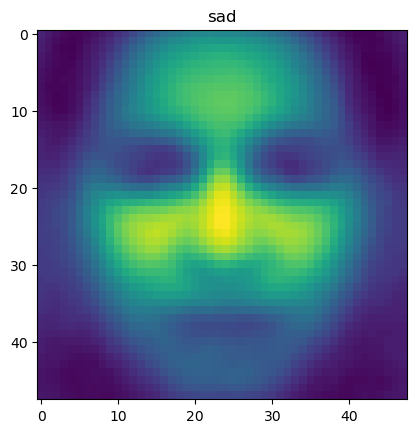

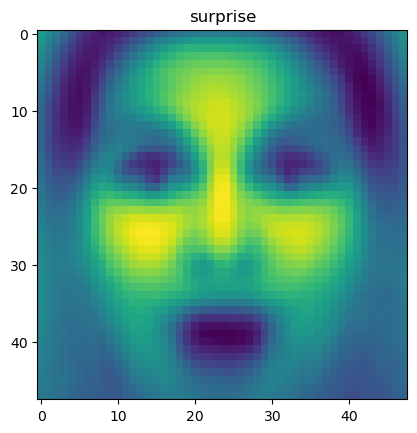

In [23]:
for i in emotions:
    series_obj = pd.Series(d[f"df_{i}"].mean())
    arr = series_obj.values
    reshaped_arr = arr.reshape((48, 48))
    plt.figure()
    plt.imshow(reshaped_arr)
    plt.title(i)

C:\Users\admindc\AppData\Local\Temp\ipykernel_8052\3781802080.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


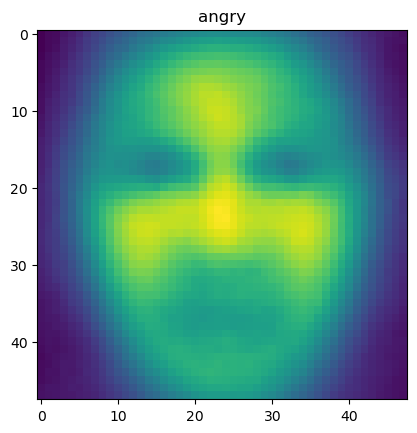

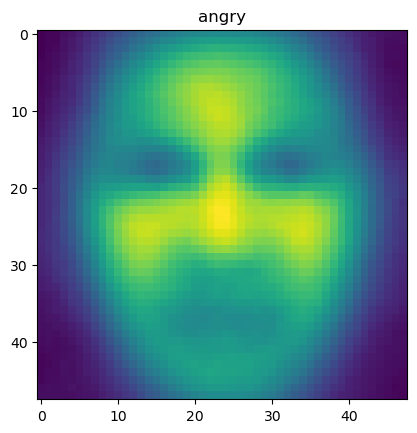

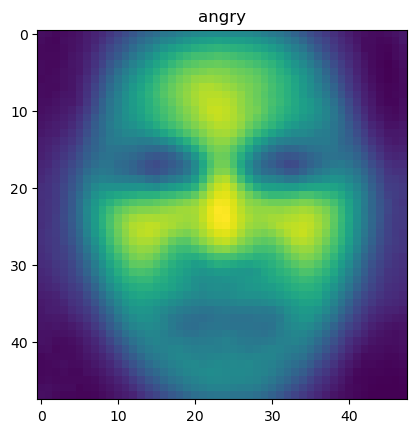

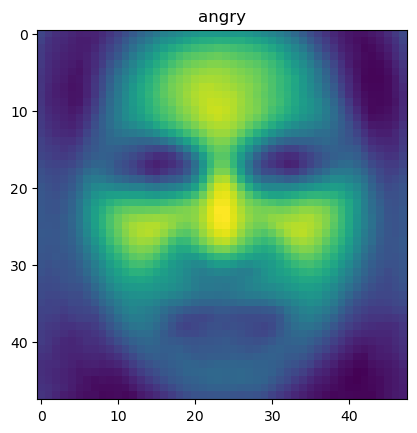

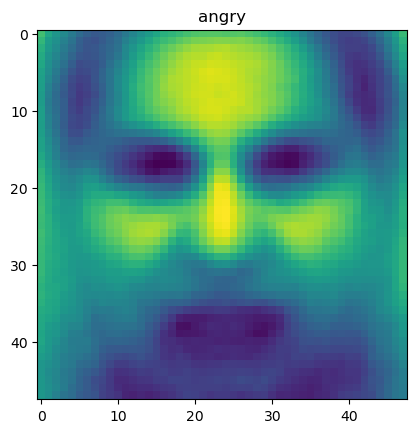

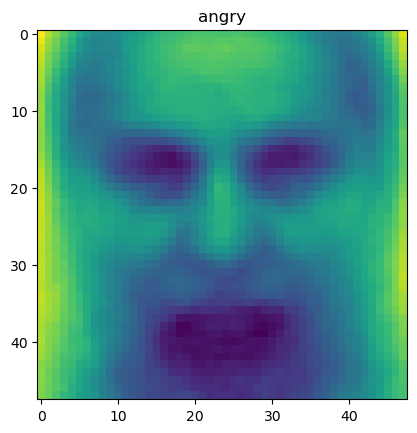

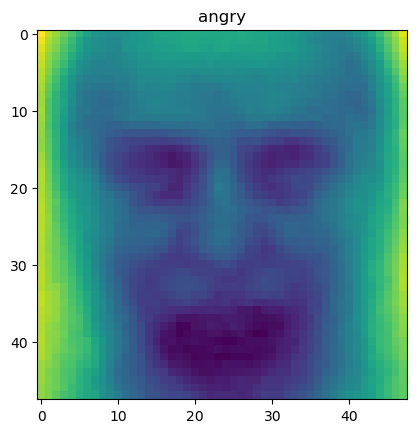

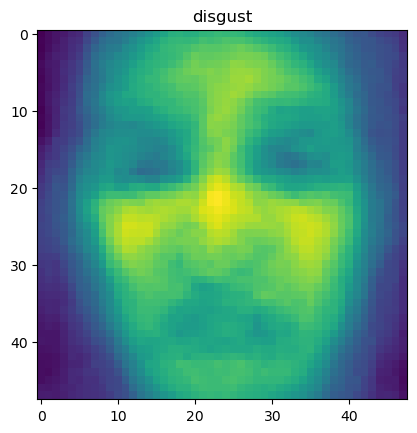

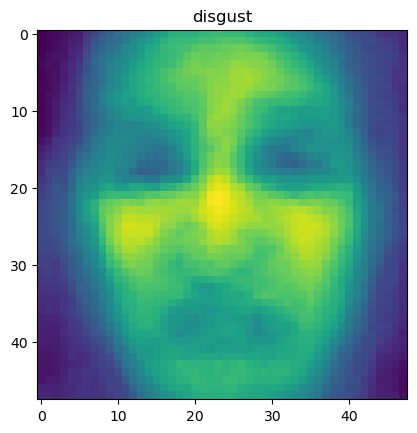

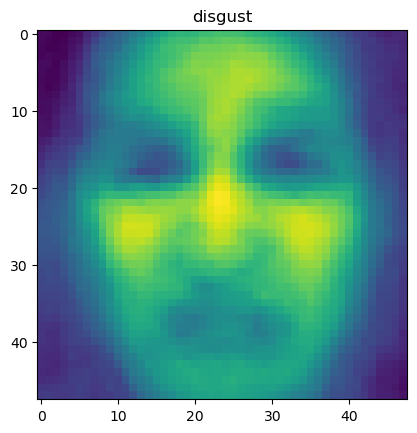

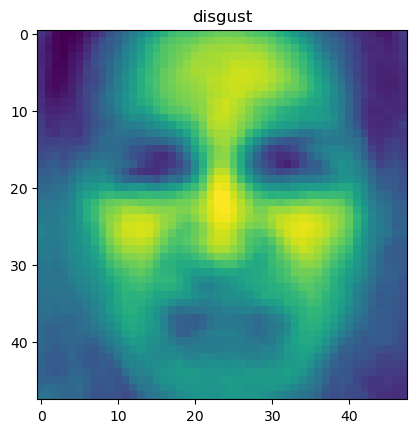

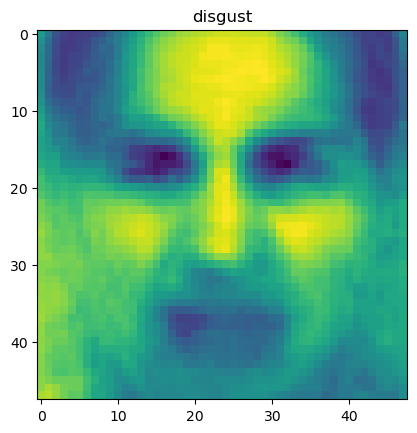

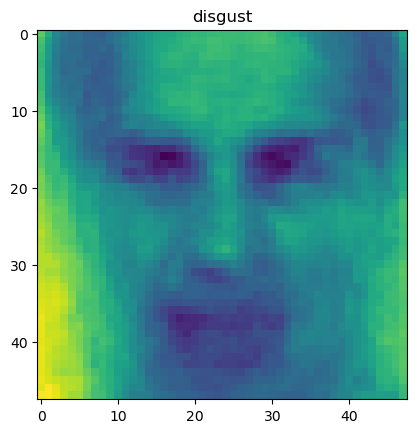

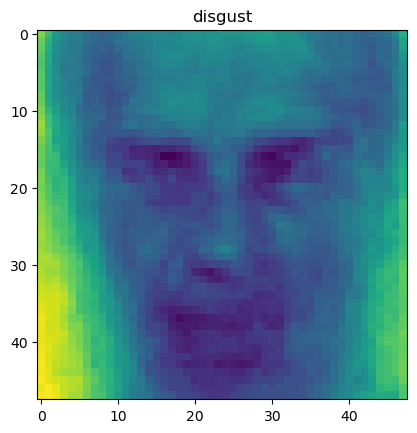

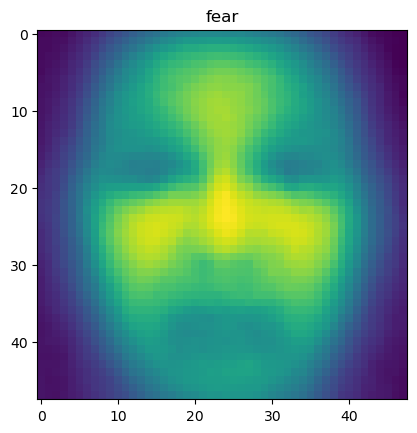

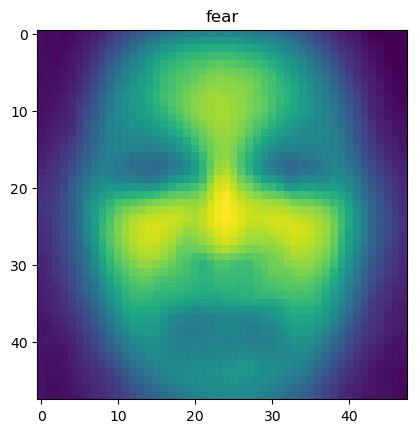

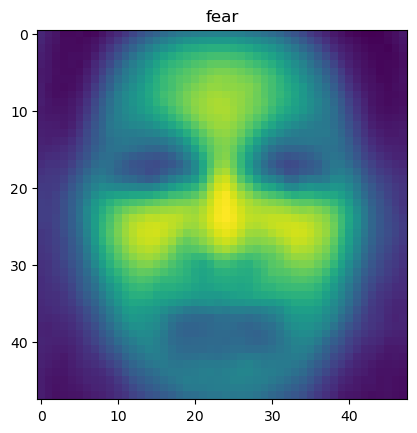

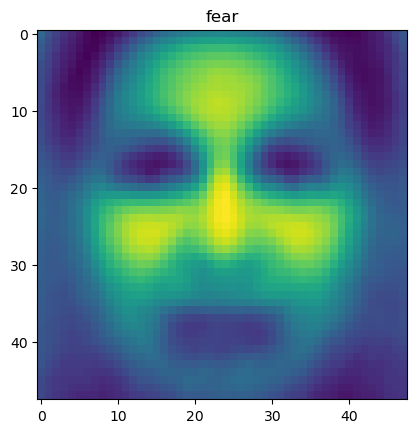

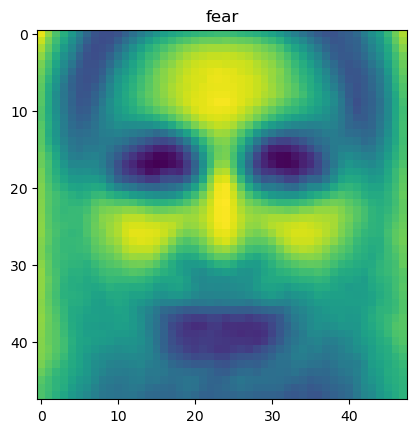

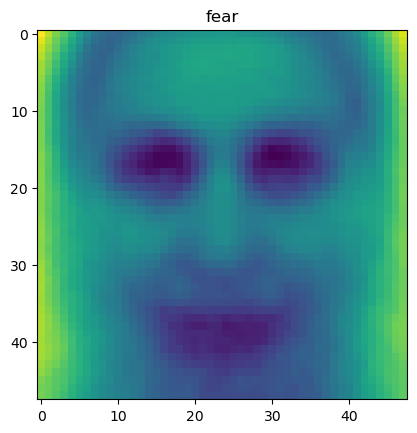

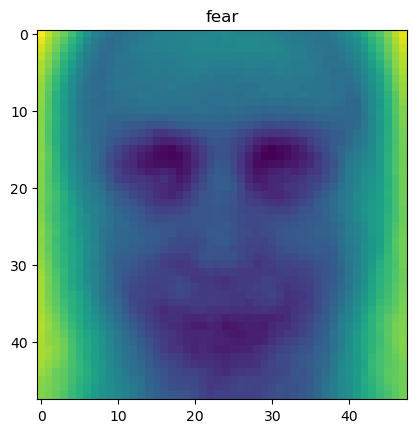

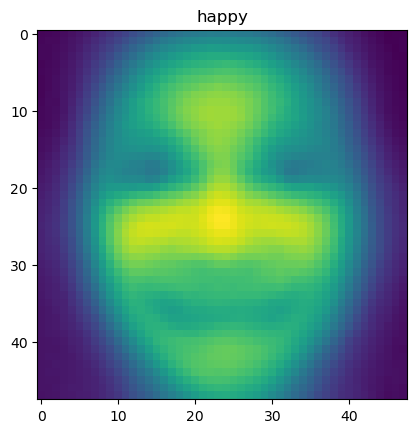

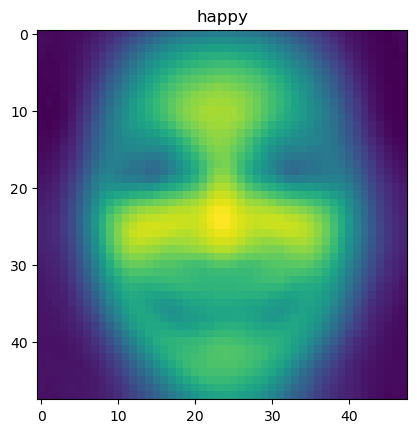

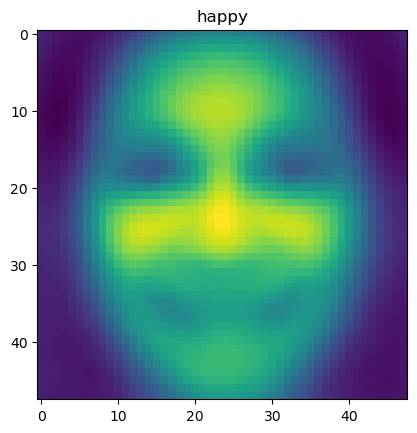

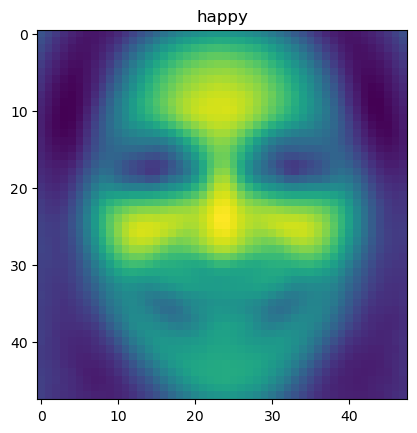

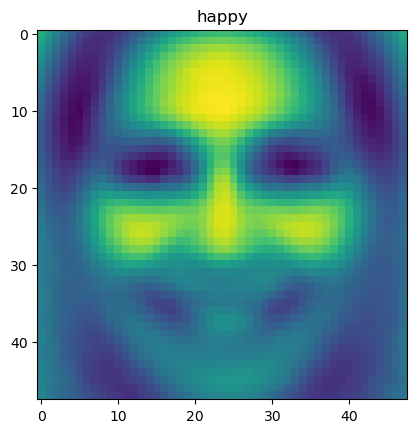

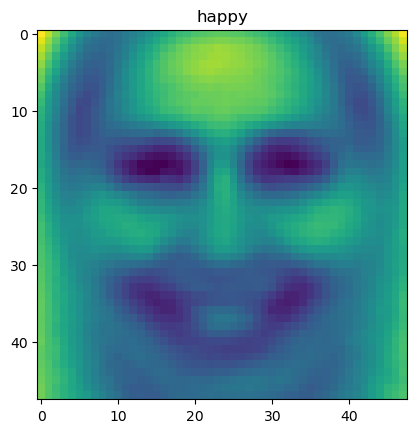

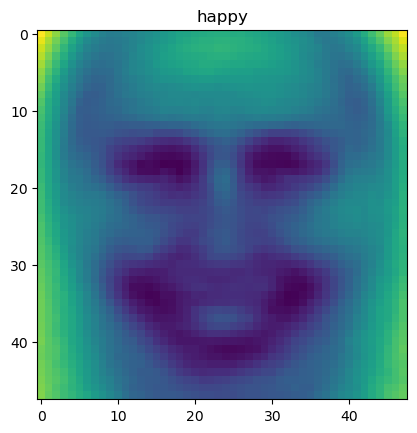

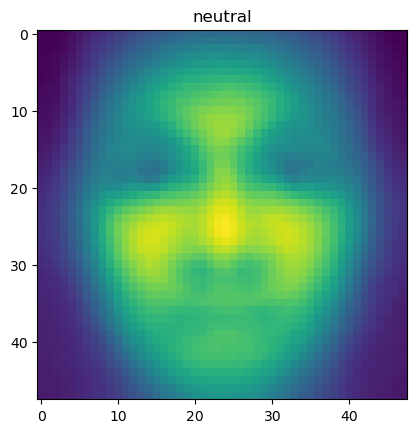

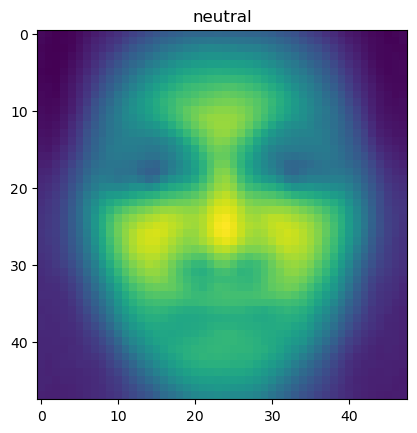

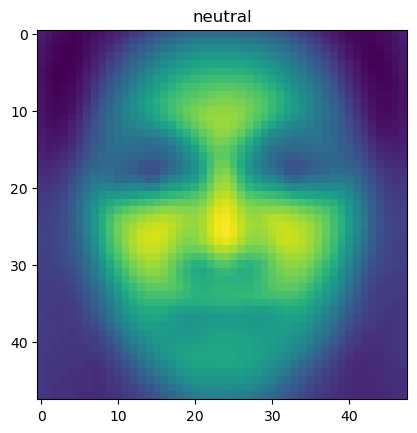

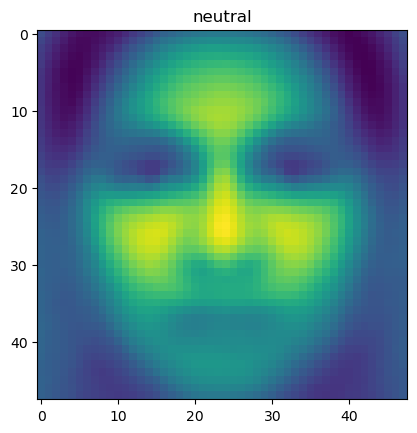

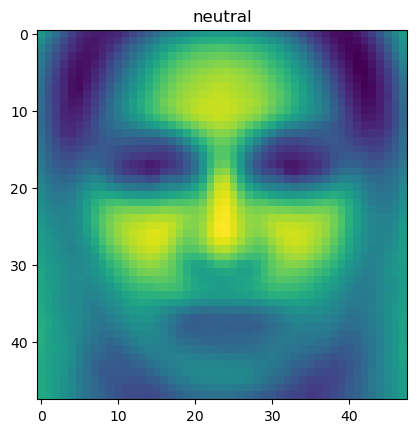

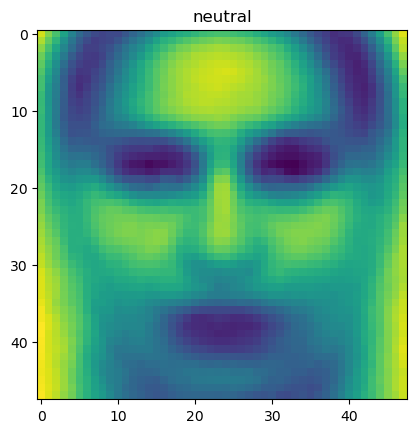

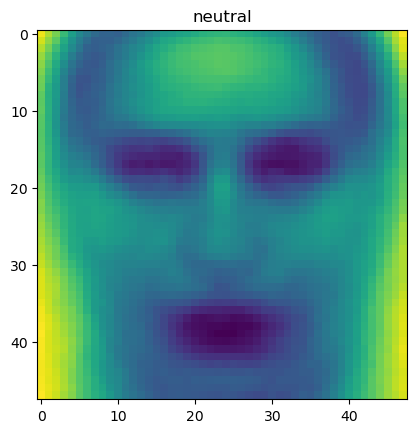

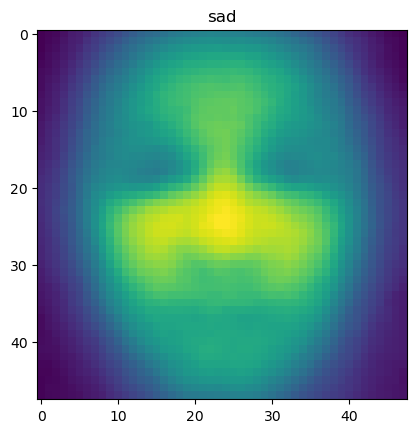

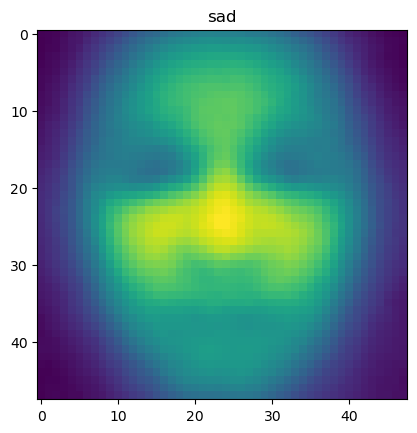

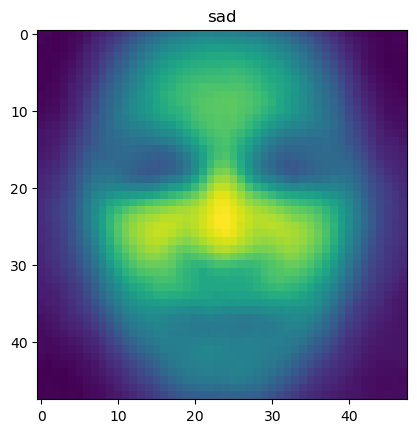

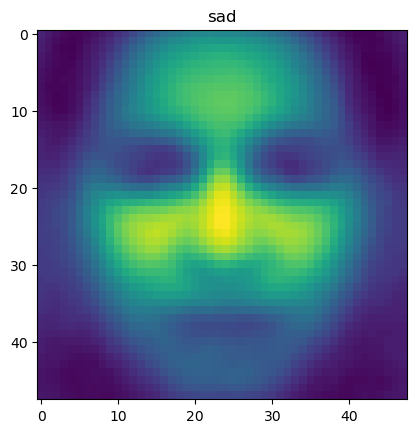

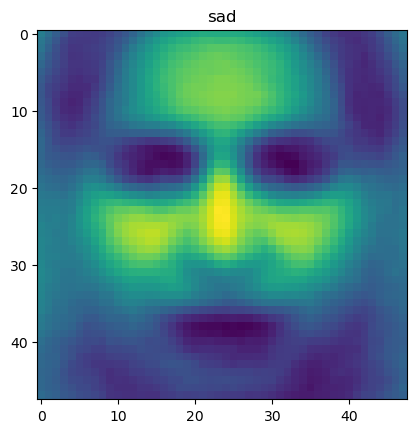

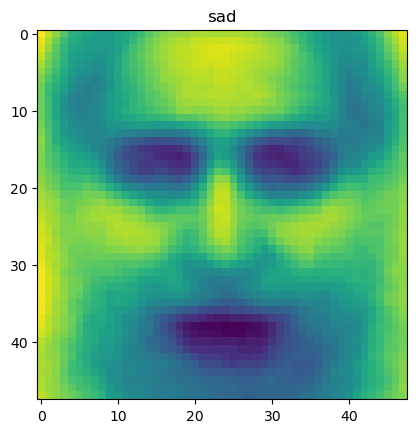

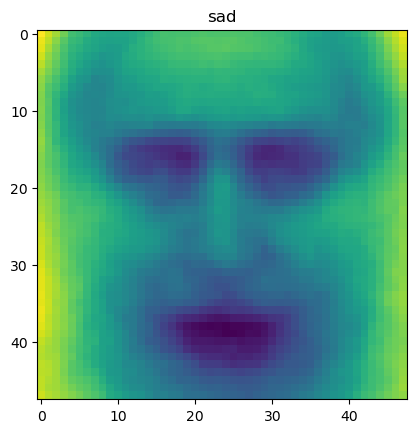

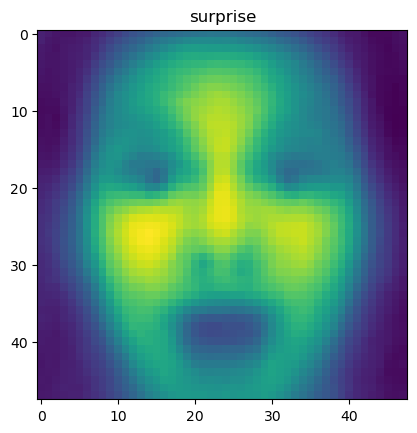

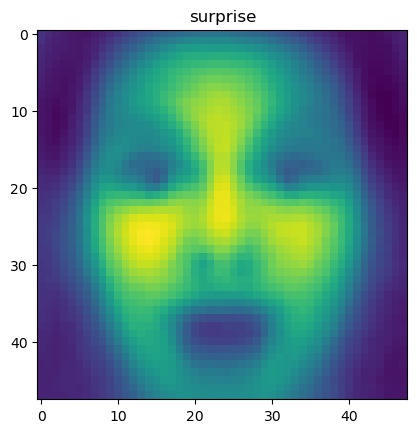

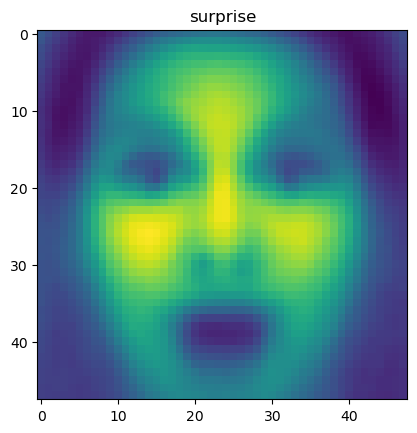

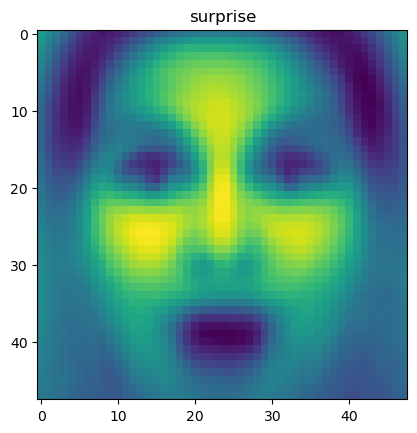

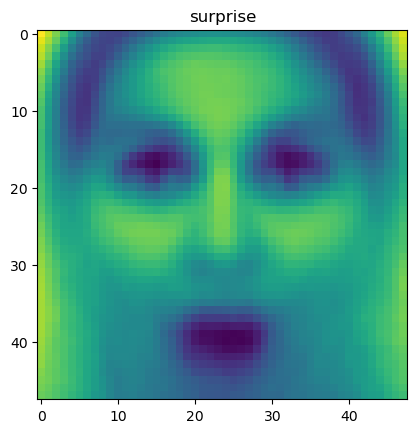

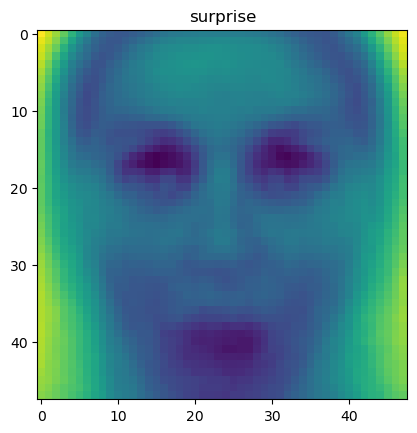

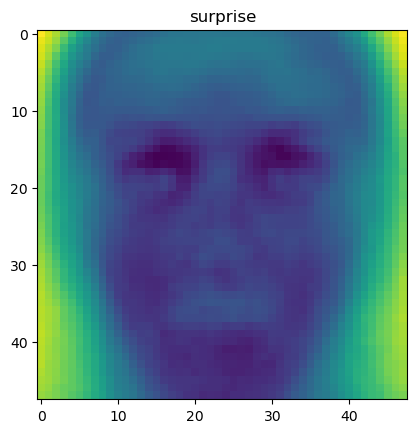

In [60]:
range_j = np.arange(-3 , 4, 1)
for i in emotions:
    for j in range_j:
        series_obj = pd.Series(d[f"df_{i}"].mean()+j*d[f"df_{i}"].std())
        arr = series_obj.values
        reshaped_arr = arr.reshape((48, 48))
        plt.figure()
        plt.imshow(reshaped_arr)
        plt.title(i)

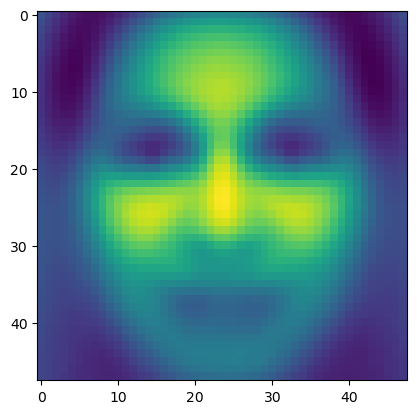

In [19]:
series_obj = pd.Series(df_tot_train.mean())
arr = series_obj.values
reshaped_arr = arr.reshape((48, 48))
plt.imshow(reshaped_arr)
plt.show()


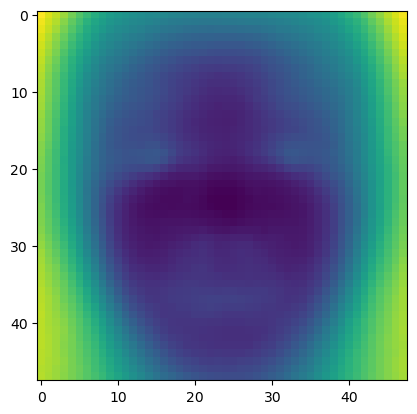

In [20]:
series_obj = pd.Series(df_tot_train.var())
arr = series_obj.values
reshaped_arr = arr.reshape((48, 48))
plt.imshow(reshaped_arr)
plt.show()


**Recher d'anomalies parmmis les photos fain d'éliminer de potentiels outliers**

In [20]:
x = 0.01 # valeur abbérante tester 1%
IsFo = IsolationForest(contamination=x, random_state=42)

IsFo.fit(df_tot_train)

c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, random_state=42)

In [21]:
In_Out = IsFo.predict(df_tot_train)
In_Out

array([ 1,  1, -1, ...,  1,  1,  1])

In [22]:
Is_Out = (In_Out == -1)
Is_Out.sum()

288

In [ ]:
df_anom = df_tot_train[Is_Out]
for i in range(len(df_anom)):
    series_obj = pd.Series(df_anom.iloc[i])
    arr = series_obj.values
    reshaped_arr = arr.reshape((48, 48))
    plt.imshow(reshaped_arr)
    plt.figure()


In [137]:
flip(df_tot_train.iloc[0])

NameError: name 'flip' is not defined

In [25]:
img_size = 48

In [26]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [27]:
train_generator = train_datagen.flow_from_directory(directory = data_dir_train,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 512,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = data_dir_test,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 512,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              shuffle = True,
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [28]:
model= tf.keras.models.Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Convolution2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
# model.add(Convolution2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Convolution2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(32,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
# model.add(Dense(512,activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [102]:
epochs = 30
batch_size = 64

In [63]:
history = model.fit(x = x_train, y=y_train ,epochs = epochs, batch_size=batch_size)

Epoch 1/30


ValueError: in user code:

    File "c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 48, 48, 1), found shape=(None, 2304)


In [92]:
base_resnet = ResNet50(input_shape=(48, 48, 3), include_top=False)
for layer in base_resnet.layers[:30]:
    layer.trainable = False

inputs = Input((48,48,1))

x = Convolution2D(3, 1, 1, padding="same")(inputs)
x = Resizing(48,48)(x)
x = preprocess_input(x)
x = base_resnet(x)

x = Flatten()(x)

x = Dense(50, activation="relu")(x)
x = Dense(10, activation="softmax")(x)

resnet = Model(inputs, x, name="resnet")

resnet.compile(optimizer=Adam(),
            loss = SparseCategoricalCrossentropy(),
            metrics=["accuracy"])

In [32]:
(x_train, x_test, y_train, y_test) = train_test_split(dataframe_proj, labels_train,
                                                    test_size=0.25, # 0.25 
                                                    random_state=42) # 4 arbirary , can be any integer

In [33]:
X_train = []
for i in range(len(x_train)):
  x0 = np.array([x_train.iloc[i]])
  x0 = x0.reshape((1,48,48))
  x0 = x0.reshape((48,48))
  X_train.append(x0)
X_train = tf.convert_to_tensor(X_train)
X_test = []
for i in range(len(x_test)):
  x0 = np.array([x_test.iloc[i]])
  x0 = x0.reshape((1,48,48))
  x0 = x0.reshape((48,48))
  X_test.append(x0)
X_test = tf.convert_to_tensor(X_test)

In [39]:
def get_cnn(n_class, activation: str = 'relu') -> tf.keras.Sequential:
    model = tf.keras.Sequential([
        # Convolution layers need 3 dimensions for the images.
        # The third dimensions is for the color channels
        Reshape((48, 48, 1)),
        Rescaling(1./255),
        RandomBrightness(factor=0.7),

        Convolution2D(filters=32, kernel_size=2, activation=activation),
        Convolution2D(filters=64, kernel_size=2, activation=activation),
        MaxPooling2D(2),
        BatchNormalization(),
        Dropout(0.25),

        Convolution2D(filters=128, kernel_size=2, activation=activation),
        MaxPooling2D(2),
        BatchNormalization(),
        Dropout(0.25),


        Convolution2D(filters=256, kernel_size=2, activation=activation),
        MaxPooling2D(2),
        BatchNormalization(),
        Dropout(0.25),


        Flatten(),

        Dense(128, activation=activation),
        Dense(256, activation=activation),

        Dense(n_class, activation='softmax')

    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def plot_cm(y_true: np.array, y_pred: np.array) -> None:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 8))
    plt.title('Confusion Matrix\n')
    sns.heatmap(cm, cmap='vlag', annot=True, fmt='d', cbar=False)
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    plt.show()


In [40]:
cnn = get_cnn(7)
history = cnn.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=16, epochs=20, validation_split=0.2)

Epoch 1/20
1346/1346 [==============================] - 181s 131ms/step - loss: 2.0815 - accuracy: 0.2024 - val_loss: 1.8310 - val_accuracy: 0.2538
Epoch 2/20
1346/1346 [==============================] - 182s 135ms/step - loss: 1.8265 - accuracy: 0.2480 - val_loss: 1.8084 - val_accuracy: 0.2538
Epoch 3/20
1346/1346 [==============================] - 194s 144ms/step - loss: 1.8197 - accuracy: 0.2479 - val_loss: 1.8087 - val_accuracy: 0.2537
Epoch 4/20
1346/1346 [==============================] - 175s 130ms/step - loss: 1.8193 - accuracy: 0.2493 - val_loss: 1.9053 - val_accuracy: 0.2537
Epoch 5/20
1346/1346 [==============================] - 143s 106ms/step - loss: 1.8177 - accuracy: 0.2493 - val_loss: 1.8073 - val_accuracy: 0.2537
Epoch 6/20
1346/1346 [==============================] - 142s 106ms/step - loss: 1.8226 - accuracy: 0.2493 - val_loss: 1.8100 - val_accuracy: 0.2537
Epoch 7/20
1346/1346 [==============================] - 142s 106ms/step - loss: 1.8149 - accuracy: 0.2502 - val_

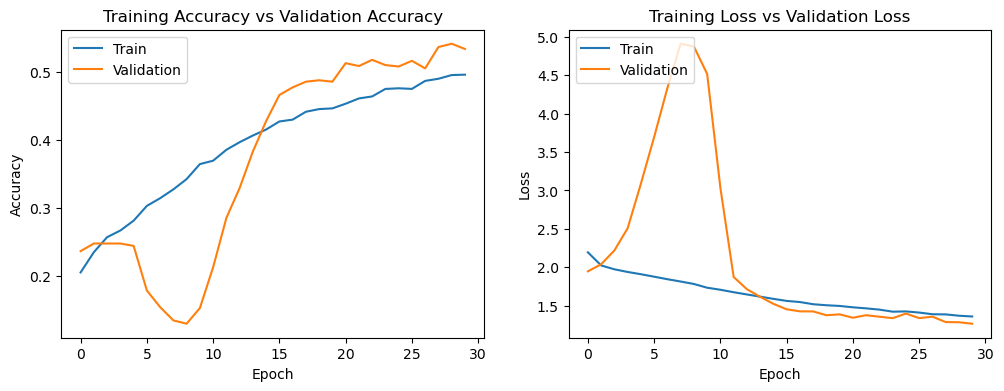

In [33]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [34]:
model.save('model_optimal_with_shuffle_2.h5')

(48, 48)


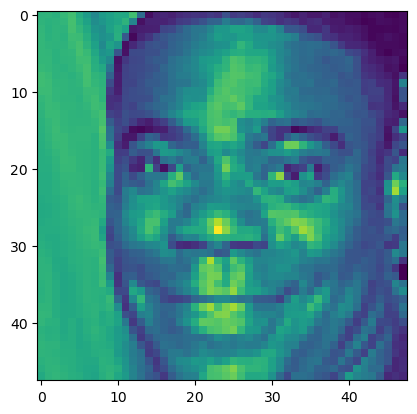

In [35]:
from keras.preprocessing import image
img = tf.keras.utils.load_img(f"{data_dir_test}happy/PrivateTest_95094.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [36]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [37]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 230ms/step
[0.0, 0.0, 2.0686647e-20, 0.0, 0.0, 0.0, 1.0]


In [38]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Surprise


In [39]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

3/3 [==============================] - 3s 984ms/step - loss: 1.2665 - accuracy: 0.5335
final train accuracy = 52.47 , validation accuracy = 53.35


In [ ]:
model.save_weights('model_weights.h5')

In [ ]:
# face = load_dataset("FastJobs/Visual_Emotional_Analysis", verbose=False)

In [ ]:
face.head()